### Universidade Federal do Tocantins
#### Curso: Ciência da Computação
#### Disciplina: Redes Neurais e Aprendizado Profundo (Deep Learning)
#### Professor: Dr. Marcelo Lisboa Rocha
#### Acadêmico: Antonio André Bacelos Chagas

##### Construção de um modelo CNN (com Transfer Learning - EfficientNetB0) para detecção de tumores cerebrais a partir de imagens de ressonância magnética (MRI) utilizando TensorFlow e Keras.

##### Data set utilizado: [Kaggle Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importação das bibliotecas necessárias
import os

import tensorflow as tf
import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import EfficientNetB0 # NOVO: Para Transfer Learning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Configuração dos diretórios do dataset
from pathlib import Path

# Diretórios candidatos locais (ajuste se mover o notebook ou o dataset)
possible_base_dirs = [
    Path("/content/drive/MyDrive/Colab Notebooks/trabalho_final"),
    Path.cwd(),
    Path.cwd().parent,
]

base_dir = None
train_dir = None
test_dir = None
checked_paths = []

for candidate in possible_base_dirs:
    candidate = candidate.expanduser().resolve()
    if str(candidate) in checked_paths:
        continue
    checked_paths.append(str(candidate))

    train_candidate = candidate / "Training"
    test_candidate = candidate / "Testing"

    if train_candidate.is_dir() and test_candidate.is_dir():
        base_dir = candidate
        train_dir = train_candidate
        test_dir = test_candidate
        break

if base_dir is None:
    detalhes = "\n".join(f"  - {path}" for path in checked_paths)
    raise FileNotFoundError(
        "Não foi possível localizar as pastas 'Training' e 'Testing'.\n"
        "Verifique os caminhos locais e ajuste 'possible_base_dirs'.\n"
        f"Caminhos verificados:\n{detalhes}"
    )

base_dir = str(base_dir)
train_dir = str(train_dir)
test_dir = str(test_dir)

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
num_classes = len(classes)

print(f"Diretório base detectado: {base_dir}")
print(f"Diretório de treino: {train_dir}")
print(f"Diretório de teste: {test_dir}")
print(f"Classes: {classes}")

Diretório base detectado: /content/drive/MyDrive/Colab Notebooks/trabalho_final
Diretório de treino: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Training
Diretório de teste: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Testing
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
# Configuração dos diretórios de checkpoints/modelos
from pathlib import Path

# Garante que base_dir seja um objeto Path
base_path = Path(base_dir)

# Define o diretório de checkpoints
checkpoints_dir = base_path / "checkpoints_modelo_1"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

# Definição dos caminhos dos arquivos
modelo_salvo_path = checkpoints_dir / "best_brain_tumor_weights.weights.h5"
modelo_final_salvo_path = checkpoints_dir / "brain_tumor_classifier.keras"

print("Checkpoints e modelos serão salvos em:")
print(f"  Diretório: {checkpoints_dir}")
print(f"  Pesos do melhor modelo: {modelo_salvo_path}")
print(f"  Modelo final completo: {modelo_final_salvo_path}")

# Converter para string para garantir compatibilidade com callbacks do Keras
modelo_salvo_path = str(modelo_salvo_path)
modelo_final_salvo_path = str(modelo_final_salvo_path)

Checkpoints e modelos serão salvos em:
  Diretório: /content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo_1
  Pesos do melhor modelo: /content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo_1/best_brain_tumor_weights.weights.h5
  Modelo final completo: /content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo_1/brain_tumor_classifier.keras


In [5]:
# Contagem de imagens por classe
# Usando os.path.join para compatibilidade entre sistemas operacionais

print("\n=== Contagem de imagens no conjunto de TREINO ===")
train_counts = {}
for classe in classes:
    path = os.path.join(train_dir, classe)
    count = len(os.listdir(path))
    train_counts[classe] = count
    print(f"{classe}: {count} imagens")

print(f"\nTotal de treino: {sum(train_counts.values())} imagens")

print("\n=== Contagem de imagens no conjunto de TESTE ===")
test_counts = {}
for classe in classes:
    path = os.path.join(test_dir, classe)
    count = len(os.listdir(path))
    test_counts[classe] = count
    print(f"{classe}: {count} imagens")

print(f"\nTotal de teste: {sum(test_counts.values())} imagens")


=== Contagem de imagens no conjunto de TREINO ===
glioma: 1321 imagens
meningioma: 1339 imagens
notumor: 1595 imagens
pituitary: 1457 imagens

Total de treino: 5712 imagens

=== Contagem de imagens no conjunto de TESTE ===
glioma: 300 imagens
meningioma: 306 imagens
notumor: 405 imagens
pituitary: 300 imagens

Total de teste: 1311 imagens


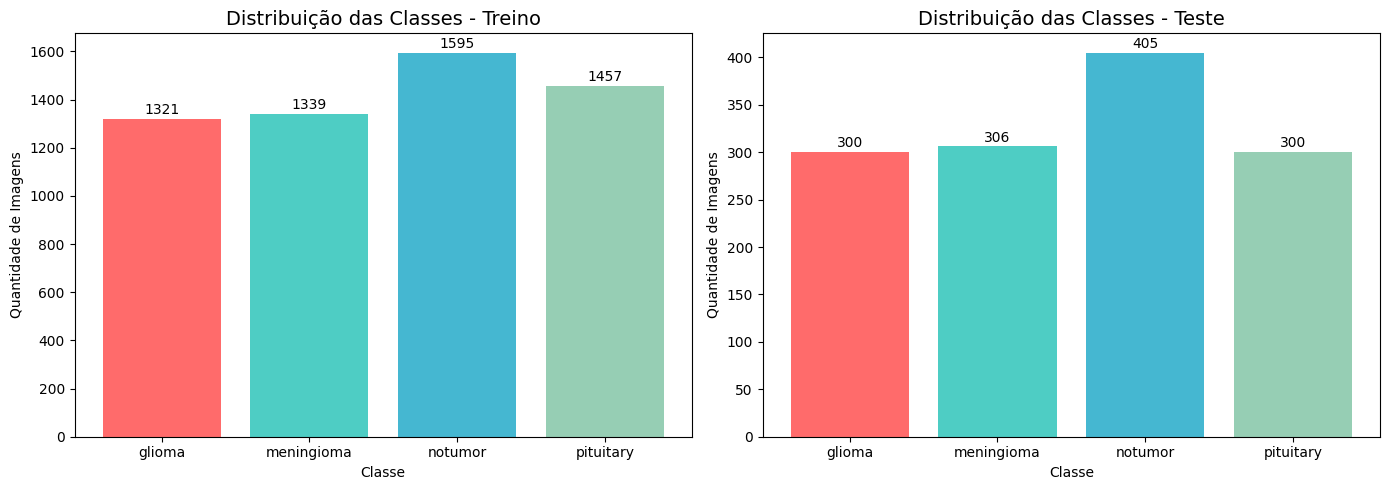

In [6]:
# Visualizar distribuição das classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de treino
axes[0].bar(train_counts.keys(), train_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0].set_title('Distribuição das Classes - Treino', fontsize=14)
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Quantidade de Imagens')
for i, (classe, count) in enumerate(train_counts.items()):
    axes[0].text(i, count + 20, str(count), ha='center', fontsize=10)

# Gráfico de teste
axes[1].bar(test_counts.keys(), test_counts.values(), color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[1].set_title('Distribuição das Classes - Teste', fontsize=14)
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Quantidade de Imagens')
for i, (classe, count) in enumerate(test_counts.items()):
    axes[1].text(i, count + 5, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
# Parâmetros de configuração
IMG_SIZE = (150, 150)  # Altura e largura das imagens
COLOR_MODE = 'rgb'     # Garantir 3 canais para o EfficientNet
CHANNELS = 3 if COLOR_MODE == 'rgb' else 1
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
BATCH_SIZE = 32        # Tamanho do batch
EPOCHS = 50            # Número máximo de épocas

print(f"Tamanho das imagens: {IMG_SIZE}")
print(f"Canais (color_mode): {COLOR_MODE} -> {CHANNELS}")
print(f"Input shape usado no modelo: {INPUT_SHAPE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas máximas: {EPOCHS}")

Tamanho das imagens: (150, 150)
Canais (color_mode): rgb -> 3
Input shape usado no modelo: (150, 150, 3)
Batch size: 32
Épocas máximas: 50


In [8]:
# Parâmetros para Data Augmentation
# Camada de augmentation que será aplicada DURANTE o treinamento
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),           # Rotação aleatória (±10% de 360°)
    layers.RandomTranslation(0.2, 0.2),   # Deslocamento horizontal e vertical
    layers.RandomZoom(0.2),               # Zoom aleatório
    layers.RandomFlip("horizontal"),      # Flip horizontal
], name="data_augmentation")

print("Camadas de Data Augmentation configuradas com sucesso!")

Camadas de Data Augmentation configuradas com sucesso!


In [9]:
# Carregar dados usando a API moderna keras.utils.image_dataset_from_directory

print("Carregando datasets...")

# Dataset de treino (80% do diretório Training)
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

# Dataset de validação (20% do diretório Training)
validation_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=True
)

# Dataset de teste
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    shuffle=False
)

# Obter nomes das classes
class_names = train_dataset.class_names
print(f"\nClasses encontradas: {class_names}")

# Configurar datasets para performance (Otimização do tf.data)
# NOTA: A normalização (1./255) foi movida para DENTRO do modelo (Rescaling)
# para simplificar o deploy e evitar normalização dupla.

AUTOTUNE = tf.data.AUTOTUNE

# Para treino: cache + shuffle + prefetch (Augmentation e Normalização no Modelo)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Para validação: cache + prefetch (Normalização no Modelo)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Para teste: prefetch (Normalização no Modelo)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print("Datasets carregados e otimizados com sucesso!")

Carregando datasets...
Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.

Classes encontradas: ['glioma', 'meningioma', 'notumor', 'pituitary']
Datasets carregados e otimizados com sucesso!


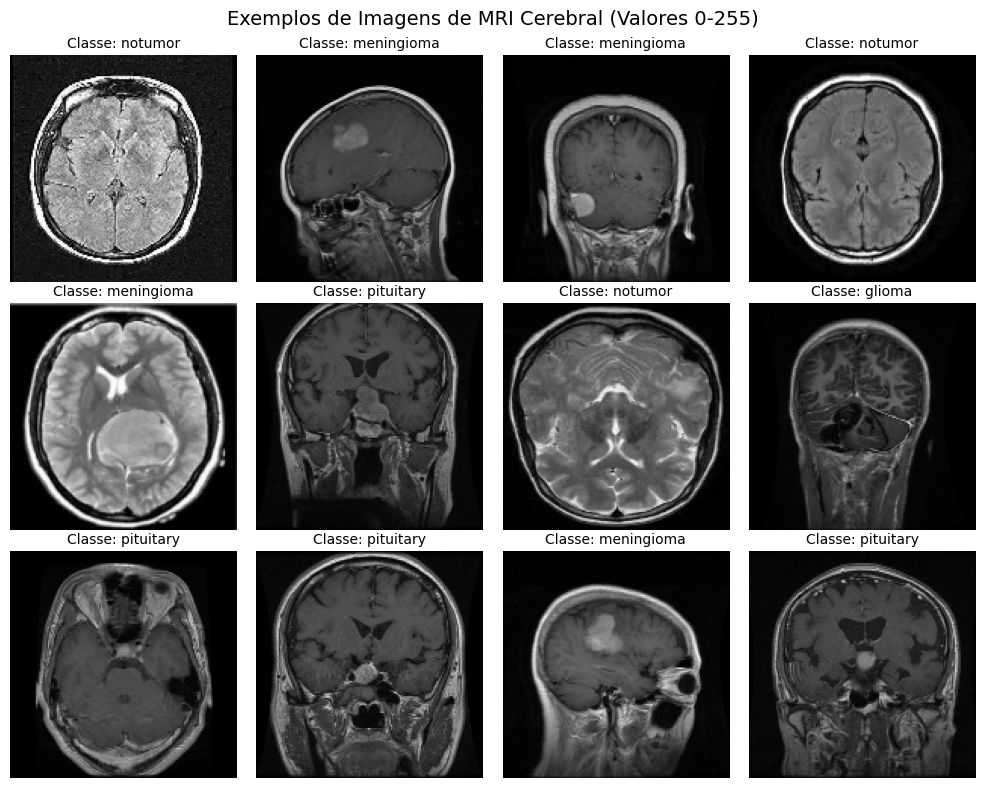

In [10]:
# Visualizar algumas imagens de exemplo
def plot_sample_images(dataset, class_names, num_images=12):
    """Plota imagens de exemplo do dataset"""
    # Obter um batch de imagens
    for images, labels in dataset.take(1):
        # Plotar
        fig, axes = plt.subplots(3, 4, figsize=(10, 8)) # Tamanho ajustado
        axes = axes.flatten()

        # Se o modelo não foi criado ainda, as imagens não estão normalizadas (0-255)
        # Para visualização, garantimos que os valores estejam entre 0 e 1 (ou 0-255)
        # Como a normalização agora está no modelo, as imagens do dataset estão em 0-255.

        for i in range(min(num_images, len(images))):
            # A conversão para int garante que a exibição de 0-255 esteja correta
            axes[i].imshow(images[i].numpy().astype('uint8'))
            label_idx = np.argmax(labels[i])
            axes[i].set_title(f"Classe: {class_names[label_idx]}", fontsize=10) # Tamanho da fonte ajustado
            axes[i].axis('off')

        plt.suptitle('Exemplos de Imagens de MRI Cerebral (Valores 0-255)', fontsize=14) # Tamanho da fonte ajustado
        plt.tight_layout()
        plt.show()

plot_sample_images(train_dataset, class_names)

In [11]:
# Construção do modelo com TRANSFER LEARNING (EfficientNetB0)
from keras.models import Model

def create_transfer_model(input_shape=(150, 150, 3), num_classes=4, data_augmentation=None):
    """Cria um modelo de Transfer Learning usando EfficientNetB0"""

    inputs = keras.Input(shape=input_shape, name="model_input")
    height, width = input_shape[:2]
    base_input_shape = (height, width, 3)  # Pesos ImageNet sempre esperam 3 canais

    # Garantir que o backbone receba 3 canais
    if input_shape[-1] == 1:
        x = layers.Concatenate(axis=-1, name="grayscale_to_rgb")([inputs, inputs, inputs])
    elif input_shape[-1] == 3:
        x = inputs
    else:
        raise ValueError("Número de canais não suportado. Use 1 (grayscale) ou 3 (rgb).")

    # 1. Aplicar Data Augmentation (apenas durante o treinamento)
    if data_augmentation:
        x = data_augmentation(x)

    # 2. Normalização (Integrada ao modelo para consistência de deploy)
    x = layers.Rescaling(1./255)(x)

    # 3. Carregar modelo base pré-treinado (EfficientNetB0)
    # 'include_top=False' remove as camadas densas finais do EfficientNet original
    requested_weights = 'imagenet'
    if input_shape[-1] != 3:
        print(f"⚠️ Input com {input_shape[-1]} canais. Pesos ImageNet exigem 3 canais; convertendo imagem e carregando pesos aleatórios.")
        requested_weights = None

    try:
        base_model = EfficientNetB0(include_top=False, weights=requested_weights, input_shape=base_input_shape)
    except ValueError as e:
        if requested_weights == 'imagenet' and "Shape mismatch" in str(e):
            print("⚠️ Não foi possível carregar os pesos ImageNet devido à incompatibilidade de canais. Prosseguindo sem pesos pré-treinados.")
            base_model = EfficientNetB0(include_top=False, weights=None, input_shape=base_input_shape)
        else:
            raise

    # Congelar (parcialmente) o modelo base para treinar apenas as camadas finais
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    x = base_model(x, training=False)  # Passa a imagem pela rede EfficientNet

    # 4. Adicionar o "Classification Head" (Camadas densas)
    x = layers.GlobalAveragePooling2D()(x)  # Substituto eficiente do Flatten

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Camada de saída
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Criar o modelo com data augmentation integrado
model = create_transfer_model(
    input_shape=INPUT_SHAPE,
    num_classes=num_classes,
    data_augmentation=data_augmentation
)

# Resumo da arquitetura
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,559 (16.71 MB)

 Trainable params: 4,169,824 (15.91 MB)

 Non-trainable params: 209,735 (819.28 KB)

In [12]:
# Compilar o modelo
# Utilizando uma Learning Rate menor (0.0001) é geralmente melhor para Transfer Learning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo compilado com sucesso!")

Modelo compilado com sucesso!


In [13]:
# Controle para reaproveitar pesos já treinados
FORCAR_RETREINAMENTO = False  # Altere para True caso deseje treinar novamente
TREINAR = True

if FORCAR_RETREINAMENTO:
    print("Treinamento forçado. Pesos anteriores serão ignorados.")
else:
    if os.path.exists(modelo_salvo_path):
        try:
            model.load_weights(modelo_salvo_path)
            TREINAR = False
            print("Pesos existentes carregados com sucesso. Treinamento será pulado.")
        except Exception as e:
            TREINAR = True
            print(f"Não foi possível carregar os pesos existentes: {e}")
    else:
        print("Nenhum arquivo de pesos encontrado. Será necessário treinar o modelo.")

Pesos existentes carregados com sucesso. Treinamento será pulado.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 260 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
# Callbacks para treinamento
callbacks = [
    # Early stopping para evitar overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Salvar os melhores pesos (arquivo definido anteriormente)
    ModelCheckpoint(
        filepath=modelo_salvo_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),

    # Reduzir learning rate quando o modelo para de melhorar
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configurados!")

Callbacks configurados!


In [15]:
# Treinar o modelo (apenas se necessário)
if TREINAR:
    print("Iniciando treinamento...\n")

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=1
    )

    print("\nTreinamento concluído!")
else:
    print("Usando modelo pré-treinado. Pulando treinamento.")

Usando modelo pré-treinado. Pulando treinamento.


In [16]:
# Plotar histórico de treinamento (apenas se treinou)
def plot_training_history(history):
    """Plota as curvas de perda e acurácia do treinamento"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Acurácia
    axes[0].plot(history.history['accuracy'], label='Treino', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validação', linewidth=2)
    axes[0].set_title('Acurácia do Modelo', fontsize=14)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Acurácia')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Perda
    axes[1].plot(history.history['loss'], label='Treino', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validação', linewidth=2)
    axes[1].set_title('Perda do Modelo', fontsize=14)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Perda')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plotar apenas se treinou nesta sessão
if TREINAR and 'history' in dir():
    plot_training_history(history)
else:
    print("ℹ️Histórico de treinamento não disponível (modelo carregado de arquivo).")

ℹ️Histórico de treinamento não disponível (modelo carregado de arquivo).


In [17]:
# Avaliar o modelo no conjunto de teste
print("Avaliando modelo no conjunto de teste...\n")

test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"\n" + "="*50)
print(f"Perda no Teste: {test_loss:.4f}")
print(f"Acurácia no Teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*50)

Avaliando modelo no conjunto de teste...

41/41 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.2908 - loss: 2.3636

Perda no Teste: 1.9214
Acurácia no Teste: 0.4851 (48.51%)


In [18]:
# Fazer predições no conjunto de teste
# Coletar todas as predições e labels verdadeiros
all_predictions = []
all_labels = []

# Nota: O dataset de teste deve ser iterado para obter todas as previsões
for images, labels in test_dataset:
    # O modelo agora lida com a normalização, então a imagem bruta é passada
    predictions = model.predict(images, verbose=0)
    all_predictions.extend(predictions)
    all_labels.extend(labels.numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

predicted_classes = np.argmax(all_predictions, axis=1)
true_classes = np.argmax(all_labels, axis=1)

print(f"\nMapeamento de classes: {dict(enumerate(class_names))}")


Mapeamento de classes: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [19]:
# Relatório de classificação
print("\n" + "="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("="*60)

print(classification_report(true_classes, predicted_classes, target_names=class_names))


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

      glioma       0.71      0.18      0.29       300
  meningioma       0.70      0.05      0.10       306
     notumor       0.60      0.88      0.72       405
   pituitary       0.33      0.69      0.45       300

    accuracy                           0.49      1311
   macro avg       0.59      0.45      0.39      1311
weighted avg       0.59      0.49      0.41      1311



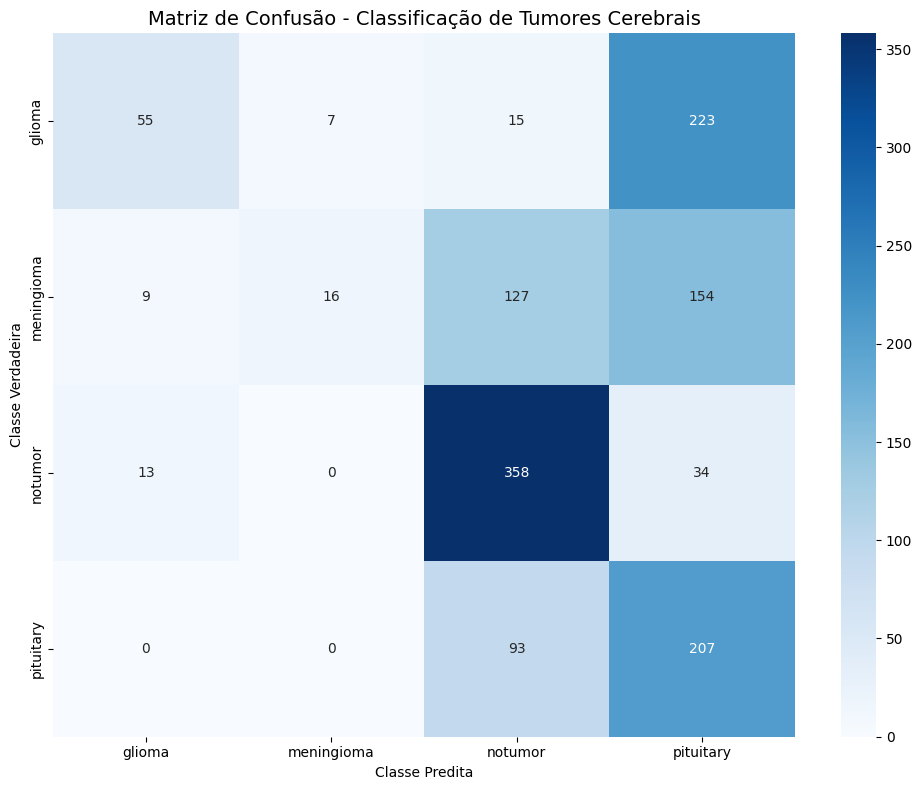


MÉTRICAS POR CLASSE

GLIOMA:
  Acurácia: 0.7963
  Precisão: 0.7143
  Recall:   0.1833
  F1-Score: 0.2918

MENINGIOMA:
  Acurácia: 0.7735
  Precisão: 0.6957
  Recall:   0.0523
  F1-Score: 0.0973

NOTUMOR:
  Acurácia: 0.7849
  Precisão: 0.6037
  Recall:   0.8840
  F1-Score: 0.7174

PITUITARY:
  Acurácia: 0.6156
  Precisão: 0.3350
  Recall:   0.6900
  F1-Score: 0.4510


In [20]:
# Matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusão - Classificação de Tumores Cerebrais', fontsize=14)
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

# Calcular métricas adicionais
print("\n" + "="*60)
print("MÉTRICAS POR CLASSE")
print("="*60)

for i, classe in enumerate(class_names):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{classe.upper()}:")
    print(f"  Acurácia: {accuracy:.4f}")
    print(f"  Precisão: {precision:.4f}")
    print(f"  Recall:   {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

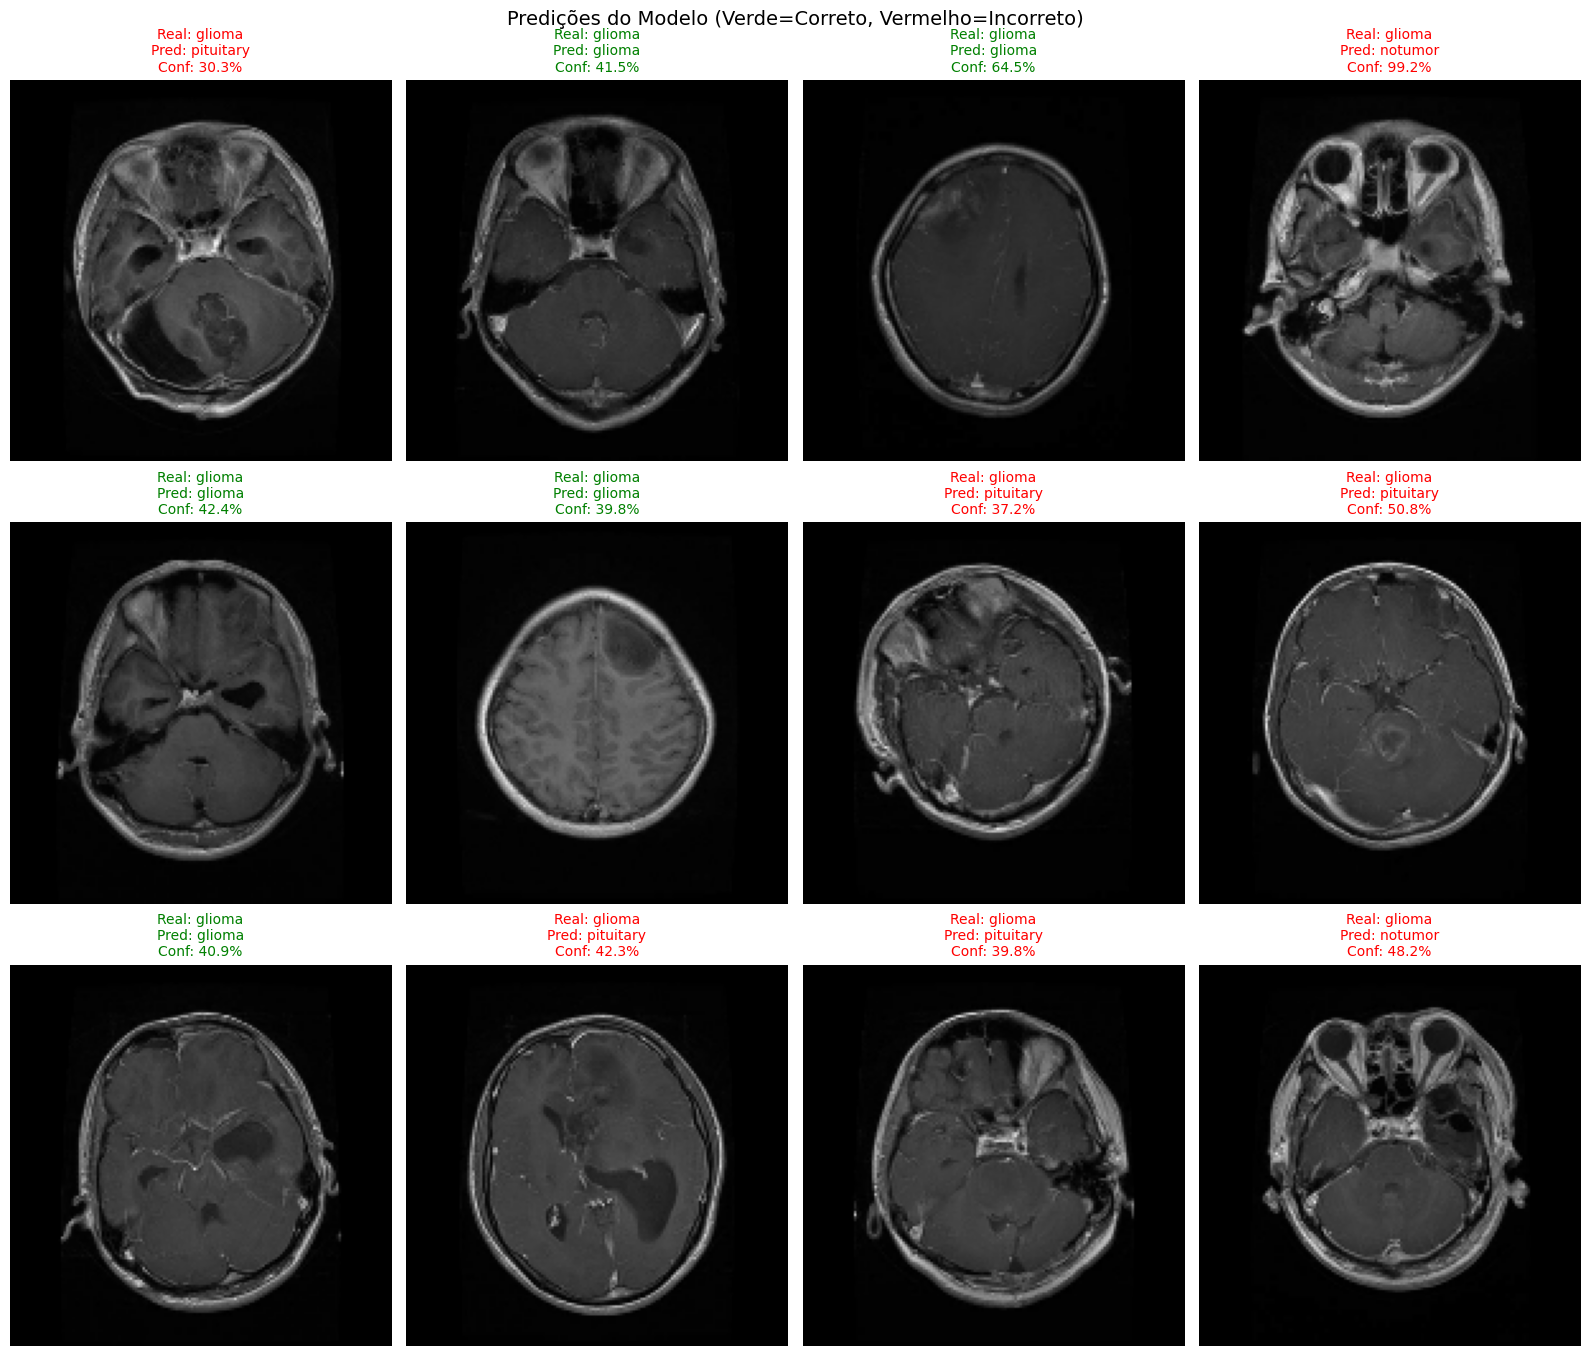

In [21]:
# Visualizar algumas predições
def plot_predictions(dataset, model, class_names, num_images=12):
    """Visualiza predições do modelo com as imagens"""
    # Obter um batch de imagens (em 0-255)
    for images, labels in dataset.take(1):
        # Predição com o modelo, que faz a normalização internamente
        predictions = model.predict(images, verbose=0)

        # Plotar
        fig, axes = plt.subplots(3, 4, figsize=(16, 14))
        axes = axes.flatten()

        for i in range(min(num_images, len(images))):
            # A conversão para int é importante para imshow exibir corretamente a imagem 0-255
            axes[i].imshow(images[i].numpy().astype('uint8'))

            true_label = class_names[np.argmax(labels[i])]
            pred_label = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i]) * 100

            color = 'green' if true_label == pred_label else 'red'

            axes[i].set_title(f"Real: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
                             fontsize=10, color=color)
            axes[i].axis('off')

        plt.suptitle('Predições do Modelo (Verde=Correto, Vermelho=Incorreto)', fontsize=14)
        plt.tight_layout()
        plt.show()

plot_predictions(test_dataset, model, class_names)

In [22]:
# Salvar o modelo final no formato moderno .keras
os.makedirs(os.path.dirname(modelo_final_salvo_path), exist_ok=True)
model.save(modelo_final_salvo_path)
print(f"Modelo salvo como '{modelo_final_salvo_path}'")

Modelo salvo como '/content/drive/MyDrive/Colab Notebooks/trabalho_final/checkpoints_modelo_1/brain_tumor_classifier.keras'


INFORMAÇÕES DA IMAGEM
📁 Nome do arquivo: Te-meTr_0000.jpg
📂 Diretório: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Testing/meningioma
📍 Caminho completo: /content/drive/MyDrive/Colab Notebooks/trabalho_final/Testing/meningioma/Te-meTr_0000.jpg


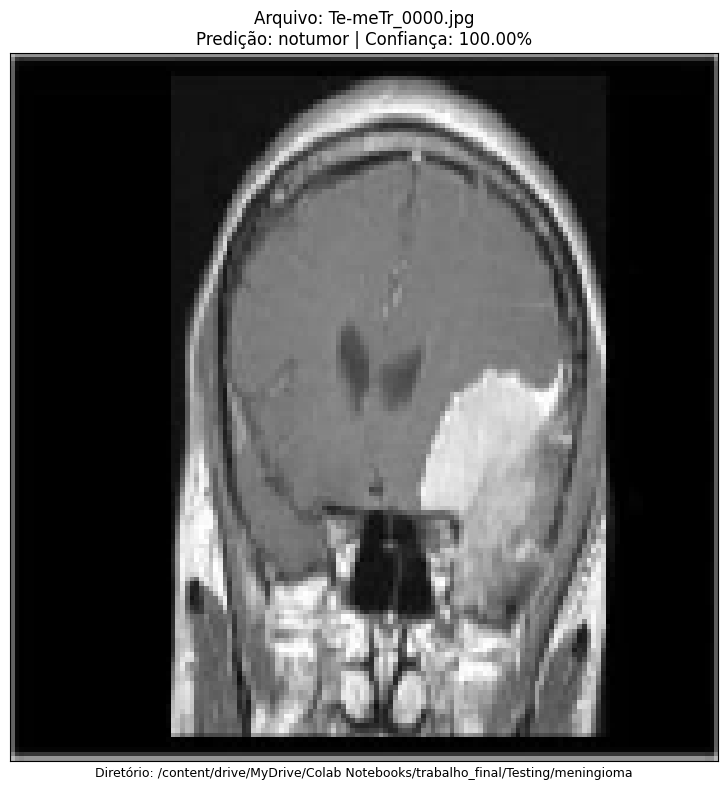


📊 Probabilidades por classe:
  glioma      :   0.00% 
  meningioma  :   0.00% 
  notumor     : 100.00% ███████████████████
  pituitary   :   0.00% 


In [23]:
# Função para fazer predição em uma única imagem
def predict_single_image(model, image_path, img_size=(150, 150)):
    """Faz predição para uma única imagem"""
    # Verificar se o arquivo existe
    if not os.path.exists(image_path):
        print(f"❌ Erro: Arquivo não encontrado: {image_path}")
        return None, None

    # Extrair informações do arquivo
    nome_arquivo = os.path.basename(image_path)
    diretorio = os.path.dirname(image_path)
    caminho_absoluto = os.path.abspath(image_path)

    # Exibir informações da imagem
    print("=" * 60)
    print("INFORMAÇÕES DA IMAGEM")
    print("=" * 60)
    print(f"📁 Nome do arquivo: {nome_arquivo}")
    print(f"📂 Diretório: {diretorio}")
    print(f"📍 Caminho completo: {caminho_absoluto}")
    print("=" * 60)

    # Usar keras.utils para carregar a imagem (API moderna)
    img = keras.utils.load_img(image_path, target_size=img_size, color_mode=COLOR_MODE)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão do batch

    # Fazer predição
    # O modelo lida com a normalização internamente (Rescaling)
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0]) * 100

    # Usar class_names que deve estar definido na célula de carregamento
    class_labels = class_names

    # Visualizar
    plt.figure(figsize=(10, 8))
    plt.imshow(keras.utils.load_img(image_path, target_size=img_size, color_mode=COLOR_MODE))
    plt.title(f"Arquivo: {nome_arquivo}\n"
              f"Predição: {class_labels[predicted_class]} | Confiança: {confidence:.2f}%",
              fontsize=12)
    plt.xlabel(f"Diretório: {diretorio}", fontsize=9)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

    # Mostrar probabilidades para cada classe
    print("\n📊 Probabilidades por classe:")
    for i, (classe, prob) in enumerate(zip(class_labels, prediction[0])):
        barra = "█" * int(prob * 20)  # Barra visual
        print(f"  {classe:12s}: {prob*100:6.2f}% {barra}")

    return class_labels[predicted_class], confidence

# Exemplo de uso com imagem do dataset de teste
try:
    exemplo_imagem = os.path.join(test_dir, "meningioma", os.listdir(os.path.join(test_dir, "meningioma"))[0])
    predicted_class, confidence = predict_single_image(model, exemplo_imagem)
except Exception as e:
    print(f"Não foi possível executar o exemplo de imagem única. Verifique o caminho do dataset. Erro: {e}")